In [1]:
import torch.nn as nn
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from datasets import DatasetDict
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

c:\Users\andre\anaconda3\envs\CNN\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5

In [3]:
torch.manual_seed(42)

# Set cuda seed if cuda
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [4]:
# True old version
# dataset = load_dataset('data')

# # Split the dataset into train and test
# train_test_split = dataset['train'].train_test_split(test_size=0.1, seed=SEED)

# dataset = DatasetDict({
#     'train': train_test_split['train'],
#     'val': train_test_split['test'],
#     'test': dataset['test'],
# })

In [5]:
dataset = load_dataset('data')

# Split the dataset into train and test
train_test_split = dataset['test'].train_test_split(test_size=0.5, seed=SEED,  stratify_by_column='label')

dataset = DatasetDict({
    'train': dataset['train'],
    'val': train_test_split['train'],
    'test': train_test_split['test'],
})

In [6]:
class MeanStdNormalize(nn.Module):
    """
    Custom transform that normalizes a tensor such that:
    - vmin = mean-std (maps to 0)
    - vmax = mean+std (maps to 1)
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, tensor):
        mean = torch.mean(tensor)
        std = torch.std(tensor)
        
        vmin = mean - std
        vmax = mean + std
        
        # Apply min-max normalization with these bounds
        normalized_tensor = (tensor - vmin) / (vmax - vmin)
        
        return normalized_tensor

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to PyTorch tensor
    #transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(),
    MeanStdNormalize(),
    # transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize if needed
])
test_transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to PyTorch tensor
    MeanStdNormalize(),
    # transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize if needed
])

def transform_examples(example, transform):
    example["pixel_values"] = [transform(image) for image in example["image"]]
    return example

dataset["train"].set_transform(lambda x: transform_examples(x, train_transform))
dataset["val"].set_transform(lambda x: transform_examples(x, test_transform))
dataset["test"].set_transform(lambda x: transform_examples(x, test_transform))

In [8]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "label": labels}

train_loader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset["val"], batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(dataset["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [9]:
class SmallResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(weights=None)

        
        # Modify for smaller image input
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # remove maxpool
        
        # Final classification layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x).squeeze()
        x = torch.sigmoid(x)
        return x
    
# Try an example
example = collate_fn([dataset["train"][0]])

model = SmallResNet()
model(example["pixel_values"])

tensor(0.7405, grad_fn=<SigmoidBackward0>)

In [10]:
model = SmallResNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS on Mac')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

In [11]:

plt.rcParams.update({
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",
    "font.size": 18
})


100%|██████████| 64/64 [03:34<00:00,  3.36s/it]


Epoch 1/5, Accuracy: 87.16%, Precision: 0.5000, Recall: 0.1429, F1 Score: 0.2222


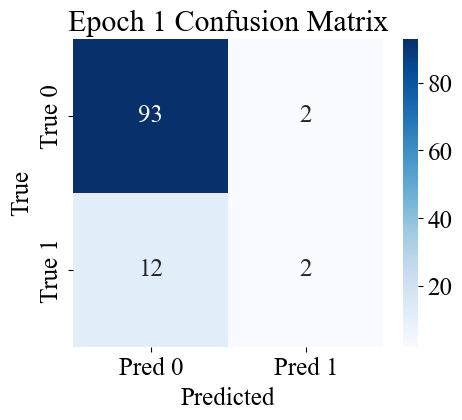

New best model saved with F1 Score: 0.2222


100%|██████████| 64/64 [02:59<00:00,  2.81s/it]


Epoch 2/5, Accuracy: 82.57%, Precision: 0.2222, Recall: 0.1429, F1 Score: 0.1739


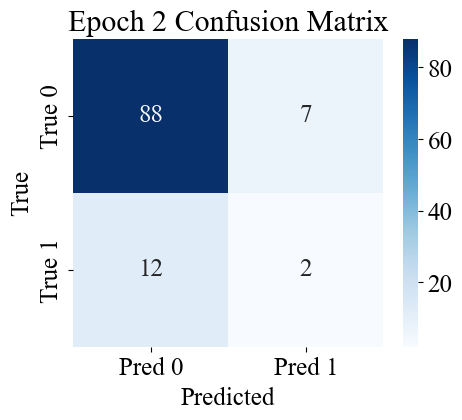

100%|██████████| 64/64 [03:00<00:00,  2.83s/it]


Epoch 3/5, Accuracy: 78.90%, Precision: 0.2000, Recall: 0.2143, F1 Score: 0.2069


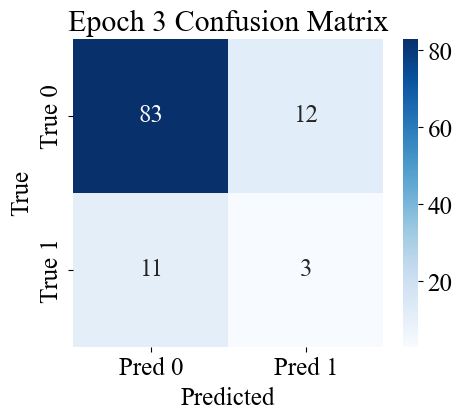

100%|██████████| 64/64 [03:03<00:00,  2.86s/it]


Epoch 4/5, Accuracy: 85.32%, Precision: 0.2500, Recall: 0.0714, F1 Score: 0.1111


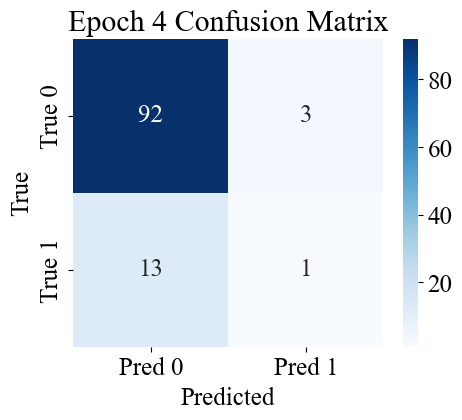

100%|██████████| 64/64 [03:08<00:00,  2.95s/it]


Epoch 5/5, Accuracy: 85.32%, Precision: 0.2500, Recall: 0.0714, F1 Score: 0.1111


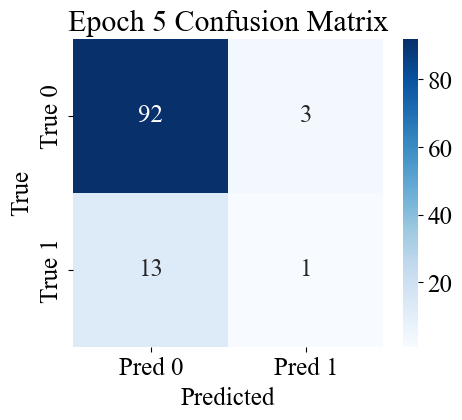

In [12]:
best_f1 = 0.0  # Initialize best F1 score
best_precision = 0.0 # Initialize best precision score
best_recall = 0.0 # Initialize best recall score
best_accuracy =  0.0 # Initialize best accuracy score


for epoch in range(EPOCHS):
    model.train()
    for batch in tqdm(train_loader):
        inputs = batch["pixel_values"].to(device)
        labels = batch["label"].float().to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        for batch in val_loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).long().view(-1)
            labels = labels.view(-1).long()

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        accuracy = 100. * correct / total
        f1 = f1_score(all_labels, all_preds, average='binary')

        #find true positives, false positives, true negatives, false negatives
        tp = sum((np.array(all_labels) == 1) & (np.array(all_preds) == 1))
        tn = sum((np.array(all_labels) == 0) & (np.array(all_preds) == 0))
        fp = sum((np.array(all_labels) == 0) & (np.array(all_preds) == 1))
        fn = sum((np.array(all_labels) == 1) & (np.array(all_preds) == 0))

        #Find precision, recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f'Epoch {epoch+1}/{EPOCHS}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

        # Confusion matrix
        
        cm = confusion_matrix(all_labels, all_preds)
        #print("Confusion Matrix:")
        #print(cm)

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Epoch {epoch+1} Confusion Matrix")
        plt.show()

        # Save best model based on precision      
        # if precision > best_precision:
        #       best_precision = precision
        #       torch.save(model.state_dict(), "best_model.pth")
        #       print(f"New best model saved with Precision: {best_precision:.4f}")  

        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_model_all_trans.pth")
            print(f"New best model saved with F1 Score: {best_f1:.4f}")

        # Save best model based on Recall
        # if recall > best_recall:
        #     best_recall = recall
        #     torch.save(model.state_dict(), "best_model.pth")
        #     print(f"New best model saved with Recall Score: {best_recall:.4f}")

        # Save best model based on all four metrics
        # if precision >= best_precision and f1 >= best_f1 and recall >= best_recall and accuracy >= best_accuracy:
        #     best_accuracy = accuracy
        #     best_precision = precision
        #     best_f1 = f1
        #     best_recall = recall
        #     torch.save(model.state_dict(), "best_model.pth")
        #     print(f"New best model saved with Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, F1 Score: {best_f1:.4f}, Recall Score: {best_recall:.4f}")

Test Accuracy: 87.16%, Test F1 Score: 0.2222


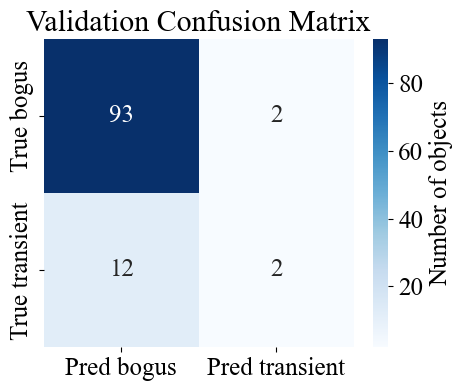

In [13]:
#confusion matrix on the validation set
model.load_state_dict(torch.load("best_model_all_trans.pth"))
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch in val_loader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        outputs = model(inputs)
        predicted = (outputs > 0.5).long().view(-1)
        labels = labels.view(-1).long()

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Test Accuracy: {accuracy:.2f}%, Test F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    #print("Confusion Matrix:")
    #print(cm)

    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred bogus", "Pred transient"],
        yticklabels=["True bogus", "True transient"]
    )

    # Add colorbar label
    colorbar = ax.collections[0].colorbar
    colorbar.set_label("Number of objects")

    plt.title("Validation Confusion Matrix")
    plt.show()


Test Accuracy: 90.00%, Test F1 Score: 0.4762


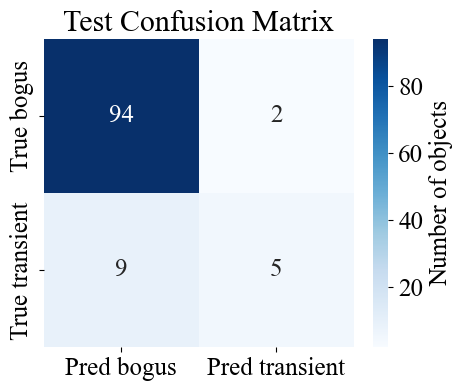

In [14]:
#confusion matrix on the test set
model.load_state_dict(torch.load("best_model_all_trans.pth"))
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch in test_loader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        outputs = model(inputs)
        predicted = (outputs > 0.5).long().view(-1)
        labels = labels.view(-1).long()

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Test Accuracy: {accuracy:.2f}%, Test F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    #print("Confusion Matrix:")
    #print(cm)

    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred bogus", "Pred transient"],
        yticklabels=["True bogus", "True transient"]
    )

    # Add colorbar label
    colorbar = ax.collections[0].colorbar
    colorbar.set_label("Number of objects")

    plt.title("Test Confusion Matrix")
    plt.show()

In [15]:
import numpy as np
from PIL import Image


# Defines the coordinates of the 3 patches to crop from the image
crop_coordinates = [
    (0, 0, 158, 158),
    (169, 0, 327, 158),
    (337, 0, 495, 158),
]  # (x1, y1, x2, y2)


def preprocessing(image_path: str) -> np.ndarray:
    """
    Loads the image
    Crops it into 3 patches
    Rescales it to (50,50)
    Stacks it into a tensor"""
    image = Image.open(image_path).convert("L")
    patches = [
        np.array(image.crop(box).resize((50, 50), Image.Resampling.LANCZOS))
        for box in crop_coordinates
    ]
    return np.stack(patches, axis=-1)

In [21]:
path = 'C:/Users/andre/MasterCode/Transient_images/Stacked_images_for_CNN/obs18'

In [22]:
import os
#from processing import preprocessing
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from astropy.table import QTable
from tqdm import tqdm  # Import tqdm

# Load best model
model = SmallResNet()
model.load_state_dict(torch.load("best_model_all_trans.pth"))
model.eval()



table = QTable(names=('ID','RA','DEC','Prediction'),dtype=('S10','f8','f8','f8'))

# Process all images in Stacked_images_for_cnn

image_paths = os.listdir(path)

# Create a folder to store images
output_folder_images = "C:/Users/andre/MasterCode/Transient_images/Predicted_images/"+ path[-5:] + "/"
os.makedirs(output_folder_images, exist_ok=True)  # Creates the folder if it doesn't exist

# Create a folder to store csv file
output_folder_csvfile = "C:/Users/andre/MasterCode/Code/Predicted_transients"
os.makedirs(output_folder_csvfile, exist_ok=True)  # Creates the folder if it doesn't exist

# Use tqdm to create a progress bar
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths), desc="Processing Images"):

    tensor = preprocessing(f'{path}/{image_path}')

    # Transform tensor using test_transform
    tensor = test_transform(tensor)

    # Add batch dimension
    tensor = tensor.unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = model(tensor)
        prediction = (output > 0.85).item()

    # Processing images with prediction 1
    if prediction == 1:
        image = Image.open(f'{path}/{image_path}').convert('L')  # Convert image to grayscale
        mean, std = np.nanmean(image), np.nanstd(image)
        # Display the image
        #print(f"Image: {image_path}, Prediction: {output.item()}")
        plt.imshow(image, vmin=mean-std, vmax=mean+std)
        #plt.show()
        #Save the image instead of showing it
        filename = os.path.join(output_folder_images, f"{image_path}")
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

    # write the name and prediction to the table
    name = os.path.splitext(image_path)[0]
    id_ra_dec = name.split('_')
    id = id_ra_dec[0]
    ra = float(id_ra_dec[1])
    dec = float(id_ra_dec[2])
    table.add_row([id, ra, dec, prediction])

csv_file_name = os.path.join(output_folder_csvfile, 'All_transformations_'+path[-5:]+'.csv')

table.write(csv_file_name, format='csv', overwrite=True)

Processing Images: 100%|██████████| 9263/9263 [05:32<00:00, 27.86it/s]


In [ ]:
import os
#from data_processing import preprocessing
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from astropy.table import QTable
from tqdm import tqdm  # Import tqdm

# Load best model
model = SmallResNet()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Create a folder to store images
output_folder = "C:/Users/andre/MasterCode/Transient_images/Predicted_images"
os.makedirs(output_folder, exist_ok=True)  # Creates the folder if it doesn't exist

table = QTable(names=('ID','RA','DEC','Prediction'),dtype=('S10','f8','f8','f8'))

# Process all images in Stacked_images_for_cnn
path = 'C:/Users/andre/MasterCode/Transient_images/Stacked_images_for_CNN'
image_paths = os.listdir(path)

# Use tqdm to create a progress bar
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths), desc="Processing Images"):

    tensor = preprocessing(f'{path}/{image_path}')

    # Transform tensor using test_transform
    tensor = test_transform(tensor)

    # Add batch dimension
    tensor = tensor.unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = model(tensor)
        prediction = (output > 0.9).item()

    # Processing images with prediction 1
    if prediction == 1:
        image = Image.open(f'{path}/{image_path}').convert('L')  # Convert image to grayscale
        mean, std = np.nanmean(image), np.nanstd(image)
        # Display the image
        #print(f"Image: {image_path}, Prediction: {output.item()}")
        plt.imshow(image, vmin=mean-std, vmax=mean+std)
        #plt.show()
        #Save the image instead of showing it
        filename = os.path.join(output_folder, f"{image_path}")
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

    # write the name and prediction to the table
    name = os.path.splitext(image_path)[0]
    id_ra_dec = name.split('_')
    id = id_ra_dec[0]
    ra = float(id_ra_dec[1])
    dec = float(id_ra_dec[2])
    table.add_row([id, ra, dec, prediction])

table.write('Predicted_transients.csv', format='csv', overwrite=True)

FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'Stacked_images_for_cnn'